In [4]:
library(nlme)
library(multcomp)
options(jupyter.plot_mimetypes = "image/png")
library(ggplot2)
library(corrplot)
library(gridExtra)
library(grid)
library(data.table)
library(effects)
library(xtable)
library(reshape)
library(lsmeans)

# Load Data

In [5]:
stat_sum_single <- function(fun, geom="point", ...) {
  stat_summary(fun.y=fun, colour="red", geom=geom, size = 3, ...)
}

In [6]:
data = read.csv("../data_meta_analysis/Data_Classifications_v7.csv")

data<-data[c('PID','Info.type','Accuracy.50','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')]

factors<-c('Info.type','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')

for (pid in unique(data$PID)){
    #print('--')
    #print(pid)
    #print(nrow(data1[data1$PID==pid,]))
    #print('--')
    data[data$PID==pid,'n_per_study']=nrow(data[data$PID==pid,])
}

R3 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_combined_regs_md.csv"))
R3names = colnames(R3)
R3names[R3names=='Outside_MD']<-'zOutside_MD'

i=1
for (name in R3names){
    R3names[i]<-paste(sep='','R3',name)
    i=i+1
}
R3names
colnames(R3)<-R3names


[1] "R3ACC"               "R3IFGop_L"           "R3IFGop_R"          
 [4] "R3Insula_L"          "R3Insula_R"          "R3MFG_L"            
 [7] "R3MFG_R"             "R3MFGorb_L"          "R3MFGorb_R"         
[10] "R3PrecG_L"           "R3PrecG_R"           "R3zOutside_MD"      
[13] "R3Insula_L.Insula_R" "R3MFG_L.MFG_R"       "R3MFGorb_L.MFGorb_R"
[16] "R3PrecG_L.PrecG_R"   "R3IFGop_L.IFGop_R"

In [7]:
data = cbind(data,R3) # will bind with other region names too 


# mscl fixed 
data<-data[!data$Classifier.type=='neural-net',] # no observations but still has a level
data[data$Scanner=='4T','Scanner']='3T' # only one observatoin with 3T

data$PID<-as.factor(data$PID)
data$Info.type<-as.factor(data$Info.type)
data$Smoothing<-as.factor(data$Smoothing)
data$Roi.Search<-as.factor(data$Roi.Search)
data$Classifier.type<-as.factor(data$Classifier.type)
data$Coregistration<-as.factor(data$Coregistration)
data$Pattern.type<-as.factor(data$Pattern.type)

#data[data$Pattern.normalization.type=='Normalized Spatially']

data$Pattern.normalization.type<-as.factor(data$Pattern.normalization.type)

data<-droplevels(data)

data_50<-subset(data,!is.na(Accuracy.50))
data_50_non<-subset(data,!is.na(Accuracy.50)& Significance==0)
data_50_sig<-subset(data,!is.na(Accuracy.50) & Significance==1)
#head(data_50_sig)
nrow(data_50_sig)




[1] 506

In [8]:
d<-data_50_sig[c('Accuracy.50','PID',R3names)]
head(d)
nrow(d)

,Accuracy.50,PID,R3ACC,R3IFGop_L,R3IFGop_R,R3Insula_L,R3Insula_R,R3MFG_L,R3MFG_R,R3MFGorb_L,R3MFGorb_R,R3PrecG_L,R3PrecG_R,R3zOutside_MD,R3Insula_L.Insula_R,R3MFG_L.MFG_R,R3MFGorb_L.MFGorb_R,R3PrecG_L.PrecG_R,R3IFGop_L.IFGop_R
2,0.52,93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.52,93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.52,93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.52,93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.525,93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.53,93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[1] 506

# Mixed Effects 

In [9]:
R1names_string<-c()
for (R in R3names){
    R1names_string<-paste(R1names_string,R,sep='+')
    
}
R1names_string<-substring(R1names_string, 2)
R1names_string

[1] "R3ACC+R3IFGop_L+R3IFGop_R+R3Insula_L+R3Insula_R+R3MFG_L+R3MFG_R+R3MFGorb_L+R3MFGorb_R+R3PrecG_L+R3PrecG_R+R3zOutside_MD+R3Insula_L.Insula_R+R3MFG_L.MFG_R+R3MFGorb_L.MFGorb_R+R3PrecG_L.PrecG_R+R3IFGop_L.IFGop_R"

In [10]:
d<-data_50_sig[c('Accuracy.50','PID',R3names)]
gmean<-mean(d$Accuracy.50)
d$Accuracy.50_wo_gmean<-d$Accuracy.50-gmean
region_model<-lme(as.formula(paste('Accuracy.50_wo_gmean~-1+',R1names_string,sep='')),random=~1|PID,data=d,method='REML')
summary(region_model)

Linear mixed-effects model fit by REML
 Data: d 
        AIC       BIC   logLik
  -1253.861 -1174.207 645.9307

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:  0.06398978 0.05320457

Fixed effects: as.formula(paste("Accuracy.50_wo_gmean~-1+", R1names_string,      sep = "")) 
                          Value  Std.Error  DF    t-value p-value
R3ACC                0.00541314 0.01201386 415  0.4505744  0.6525
R3IFGop_L            0.00847817 0.02047634 415  0.4140469  0.6791
R3IFGop_R           -0.00486349 0.01513734 415 -0.3212908  0.7482
R3Insula_L          -0.00789916 0.02201752 415 -0.3587670  0.7200
R3Insula_R           0.01696789 0.01686535 415  1.0060801  0.3150
R3MFG_L              0.00670807 0.01753051 415  0.3826511  0.7022
R3MFG_R              0.00398354 0.01667436 415  0.2389021  0.8113
R3MFGorb_L          -0.03107891 0.02724440 415 -1.1407447  0.2546
R3MFGorb_R           0.01253352 0.01613724 415  0.7766826  0.4378
R3PrecG_L           -0.00344283 0.018

In [11]:
#summary(region_model)

In [12]:
#lsmeans(region_model,pairwise~.,adjust='Tukey')

In [13]:
R3names

[1] "R3ACC"               "R3IFGop_L"           "R3IFGop_R"          
 [4] "R3Insula_L"          "R3Insula_R"          "R3MFG_L"            
 [7] "R3MFG_R"             "R3MFGorb_L"          "R3MFGorb_R"         
[10] "R3PrecG_L"           "R3PrecG_R"           "R3zOutside_MD"      
[13] "R3Insula_L.Insula_R" "R3MFG_L.MFG_R"       "R3MFGorb_L.MFGorb_R"
[16] "R3PrecG_L.PrecG_R"   "R3IFGop_L.IFGop_R"

In [14]:
#R3names

In [15]:
R3namesnew<-c()
for (R in R3names){
    R3namesnew<-c(R3namesnew,gsub("R3", "",R))
    
}
R3namesnew

[1] "ACC"               "IFGop_L"           "IFGop_R"          
 [4] "Insula_L"          "Insula_R"          "MFG_L"            
 [7] "MFG_R"             "MFGorb_L"          "MFGorb_R"         
[10] "PrecG_L"           "PrecG_R"           "zOutside_MD"      
[13] "Insula_L.Insula_R" "MFG_L.MFG_R"       "MFGorb_L.MFGorb_R"
[16] "PrecG_L.PrecG_R"   "IFGop_L.IFGop_R"

In [16]:
# get data for plot 
fits<-c()
se<-c()
i=1
R3names = sort(R3names)
for (name in R3names){
    ef<-effect(name,region_model)
    fits[i]<-tail(ef$fit, n=1)
    se[i]<-tail(ef$se, n=1)
    i=i+1 
}
dd = data.table(name=R3namesnew,se=se,Accuracy=fits)



In [17]:
dd$Accuracy_gmean = dd$Accuracy+gmean
head(dd)

,name,se,Accuracy,Accuracy_gmean
1,ACC,0.01468736,0.00484073,0.617969
2,IFGop_L,0.01987575,0.00813339,0.6212617
3,IFGop_R,0.03440788,-0.012142,0.6009863
4,Insula_L,0.01574824,-0.004445832,0.6086824
5,Insula_R,0.02334638,-0.007652189,0.6054761
6,MFG_L,0.02072806,-0.02368812,0.5894401


In [18]:
dd$name

[1] "ACC"               "IFGop_L"           "IFGop_R"          
 [4] "Insula_L"          "Insula_R"          "MFG_L"            
 [7] "MFG_R"             "MFGorb_L"          "MFGorb_R"         
[10] "PrecG_L"           "PrecG_R"           "zOutside_MD"      
[13] "Insula_L.Insula_R" "MFG_L.MFG_R"       "MFGorb_L.MFGorb_R"
[16] "PrecG_L.PrecG_R"   "IFGop_L.IFGop_R"

In [19]:
R3names

[1] "R3ACC"               "R3IFGop_L"           "R3IFGop_L.IFGop_R"  
 [4] "R3IFGop_R"           "R3Insula_L"          "R3Insula_L.Insula_R"
 [7] "R3Insula_R"          "R3MFG_L"             "R3MFG_L.MFG_R"      
[10] "R3MFGorb_L"          "R3MFGorb_L.MFGorb_R" "R3MFGorb_R"         
[13] "R3MFG_R"             "R3PrecG_L"           "R3PrecG_L.PrecG_R"  
[16] "R3PrecG_R"           "R3zOutside_MD"

pdf 
  2

pdf 
  2

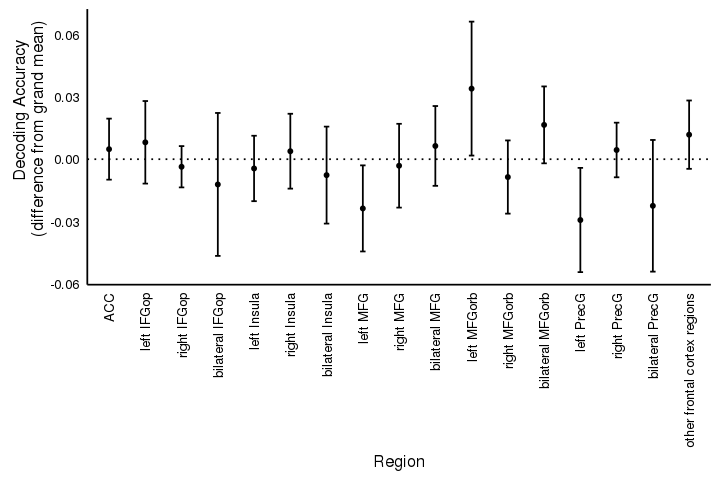

In [25]:


p<-ggplot(aes(y = Accuracy, x = name,ymax = Accuracy + se, ymin=Accuracy - se), 
          data = dd) +
geom_point(size=1)+geom_errorbar(width=0.15)

mainlinewidth=.5
textsize = 8
labelsize = 10

p<-p+geom_hline(yintercept=0,linetype='dotted')
p<-p+theme(axis.line.x = element_line(color="black", size = mainlinewidth),
        axis.line.y = element_line(color="black", size = mainlinewidth))

p<-p+xlab('Region')
p<-p+ylab('Decoding Accuracy \n (difference from grand mean)')
p<-p+theme(panel.background=element_blank())
p<-p+theme(axis.text.y = element_text(family="Helvetica",size=textsize,colour='black'))
p<-p+theme(axis.text.x = element_text(family="Helvetica",angle = 90, vjust=0.5,
                                      hjust = 1,size=textsize,colour='black'))
p<-p+theme(plot.title = element_text(family="Helvetica",size=labelsize,colour='black'))
p<-p+theme(axis.title.x = element_text(family="Helvetica",size=labelsize,,colour='black'))
p<-p+theme(axis.title.y = element_text(family="Helvetica",size=labelsize,hjust=.8,colour='black'))

rlabels = c('ACC',
             'left IFGop','right IFGop','bilateral IFGop',
             'left Insula','right Insula','bilateral Insula',
             'left MFG','right MFG','bilateral MFG',
             'left MFGorb','right MFGorb', 'bilateral MFGorb',
             'left PrecG','right PrecG','bilateral PrecG',
                     'other frontal cortex regions'
             )

p<-p+scale_x_discrete(labels=rlabels)

p<-p+theme(axis.ticks.x=element_blank(),axis.ticks.y=element_blank())

setEPS()
postscript('../Figures/Supp_accuracy_by_md_region_mixed_effects.eps',width=6,height=4)
p
dev.off()


png('../Figures/Supp_accuracy_by_md_region_mixed_effects.png',width=6,height=4,
     units="in",res=400)
p
dev.off()
options(repr.plot.width=6, repr.plot.height=4)
p

In [21]:
region_model_ml<-lme(as.formula(paste('Accuracy.50_wo_gmean~-1+',R1names_string,sep='')),random=~1|PID,data=d,method='ML')
region_model_baseline<-lme(Accuracy.50_wo_gmean~1,random=~1|PID,data=d,method='ML')
anova(region_model_ml,region_model_baseline)


,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
region_model_ml,"lme.formula(fixed = as.formula(paste(""Accuracy.50_wo_gmean~-1+"", R1names_string, sep = """")), data = d, random = ~1 | PID, method = ""ML"")",1,19,-1362.381,-1282.076,700.1903,,NA,NA
region_model_baseline,"lme.formula(fixed = Accuracy.50_wo_gmean ~ 1, data = d, random = ~1 | PID, method = ""ML"")",2,3,-1384.061,-1371.381,695.0305,1 vs 2,10.31963,0.849412
